In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import numpy as np

# Task: 1 Data Cleaning 

# Defining functions
 
def removeunnecessaryColumns(df_patients):
    # Index is not needed for analysis and patient type is a constant value
    df_patients.drop(columns=['index', 'PATIENT_TYPE'], inplace=True)
    print("Columns after removing irrelevant:")
    print(df_patients.columns)

# Identifying and handling missing values
def handleMissingValues(df_patients):

    # Make ? in pregnant 1 instead of deleting as ? means male
    df_patients['PREGNANT'] = df_patients['PREGNANT'].replace('?', 1)

    #Make all 9999-99-99 dates NaT then an average date 
    df_patients['DATE_DIED'] = pd.to_datetime(df_patients['DATE_DIED'], errors='coerce')
    average_date = pd.to_datetime(df_patients['DATE_DIED'].dropna().astype(int).mean(), unit='ns')
    df_patients['DATE_DIED'] = df_patients['DATE_DIED'].fillna(average_date)

    df_patients.replace('?', pd.NA, inplace=True)

    print("Missing values before dropping rows:")
    print(df_patients.isnull().sum())
    print(f"Dataset shape before dropping nulls: {df_patients.shape}")
    #print(df_patients.head())

    df_patients.dropna(inplace=True)

    # Check data after handling missing values 
    print("Missing values after dropping rows:")
    print(df_patients.isnull().sum())
    print(f"Dataset shape after dropping nulls: {df_patients.shape}")
    #print(df_patients.head())

# Outlier Detection and Removal using IQR
def outlierDetection(df_patients):

    # Only numeric columns for outlier detection
    numeric_cols = df_patients.select_dtypes(include=['float64', 'int64']).columns
    print("Numeric columns for outlier detection:", numeric_cols)
    print(df_patients[numeric_cols])

    # Calculating the first (Q1) and third (Q3) quartiles
    Q1 = df_patients[numeric_cols].quantile(0.25)
    Q3 = df_patients[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Removing rows that have any outliers (using 1.5 * IQR rule)
    df_patients = df_patients[~((df_patients[numeric_cols] < (Q1 - 1.5 * IQR)) | 
                                (df_patients[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    # Check data after outlier removal
    print(f"Shape after removing outliers: {df_patients.shape}")

#Normalization of the AGE column using StandardScaler
def normalizeData(df_patients):
    print(df_patients['AGE'].head())
    scaler = StandardScaler()
    df_patients['AGE'] = scaler.fit_transform(df_patients[['AGE']])

    # Check data after normalization
    print("Data after normalization:")
    print(df_patients['AGE'].head())


# Cleaning the dataset

# Loading the dataset from the CSV file
data_file = 'Dataset.csv'
df_patients = pd.read_csv(data_file, low_memory=False)

# Displaying the first few rows to inspect the data
print("First 5 rows of the dataset:")
print(df_patients.head())

# Checking the shape (number of rows and columns)
print(f"Dataset Shape: {df_patients.shape}")

# Clean the dataset
removeunnecessaryColumns(df_patients)
handleMissingValues(df_patients)
outlierDetection(df_patients)
normalizeData(df_patients)

# Save the cleaned dataset to a new CSV file
df_patients.to_csv('cleaned_patients.csv', index=False)

# Checking the data types
print("Data types before adjustment:")
print(df_patients.dtypes)

# Verify the data types and the list of columns after removal
print("Data types after adjustment:")
print(df_patients.dtypes)
print("Remaining columns:")
print(df_patients.columns)
print(f"Final dataset shape: {df_patients.shape}")

First 5 rows of the dataset:
   index  USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED INTUBED  \
0      2      2             1    2             2  09/06/2020       1   
1      5      2             1    1             2  9999-99-99       2   
2      8      2             1    1             2  9999-99-99       2   
3      9      2             1    1             2  9999-99-99       2   
4     11      2             1    2             2  9999-99-99       2   

  PNEUMONIA  AGE PREGNANT  ... ASTHMA INMSUPR HIPERTENSION OTHER_DISEASE  \
0         2   55        ?  ...      2       2            2             2   
1         1   40        2  ...      2       2            2             2   
2         2   37        2  ...      2       2            1             2   
3         2   25        2  ...      2       2            2             2   
4         2   24        ?  ...      2       2            2             2   

  CARDIOVASCULAR OBESITY RENAL_CHRONIC TOBACCO CLASIFFICATION_FINAL  ICU  
0     

C:\Users\owain\AppData\Local\Temp\ipykernel_39084\3087470711.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


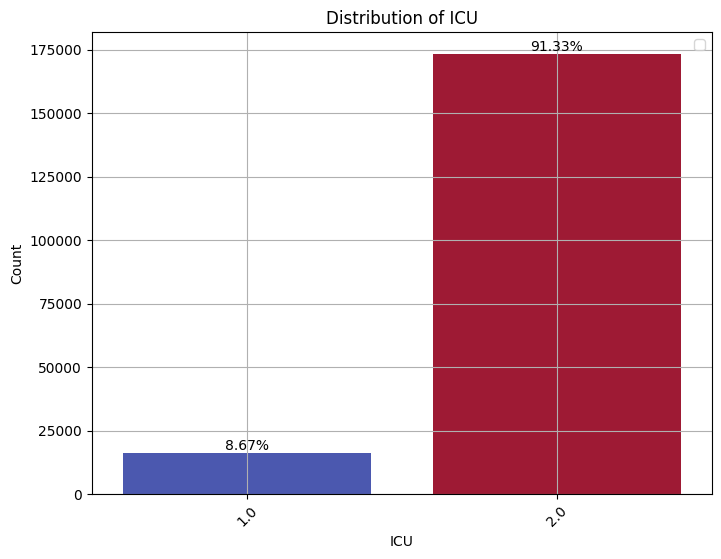

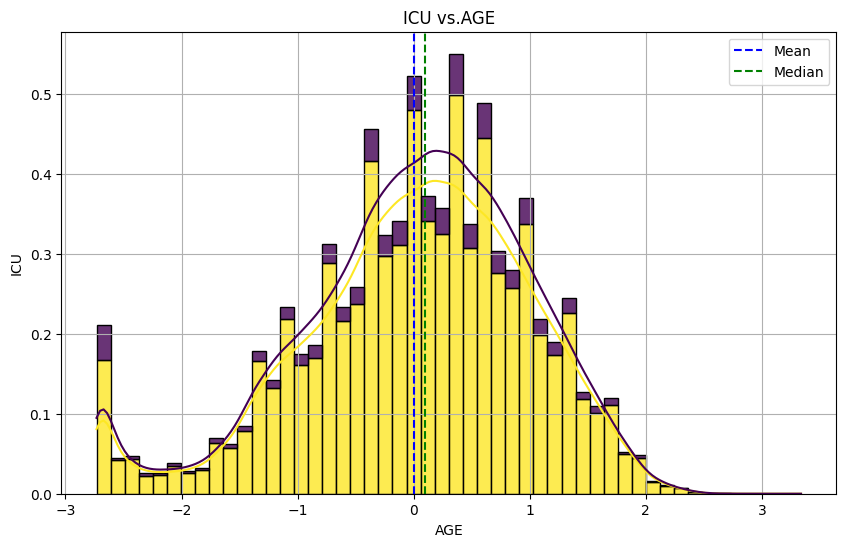

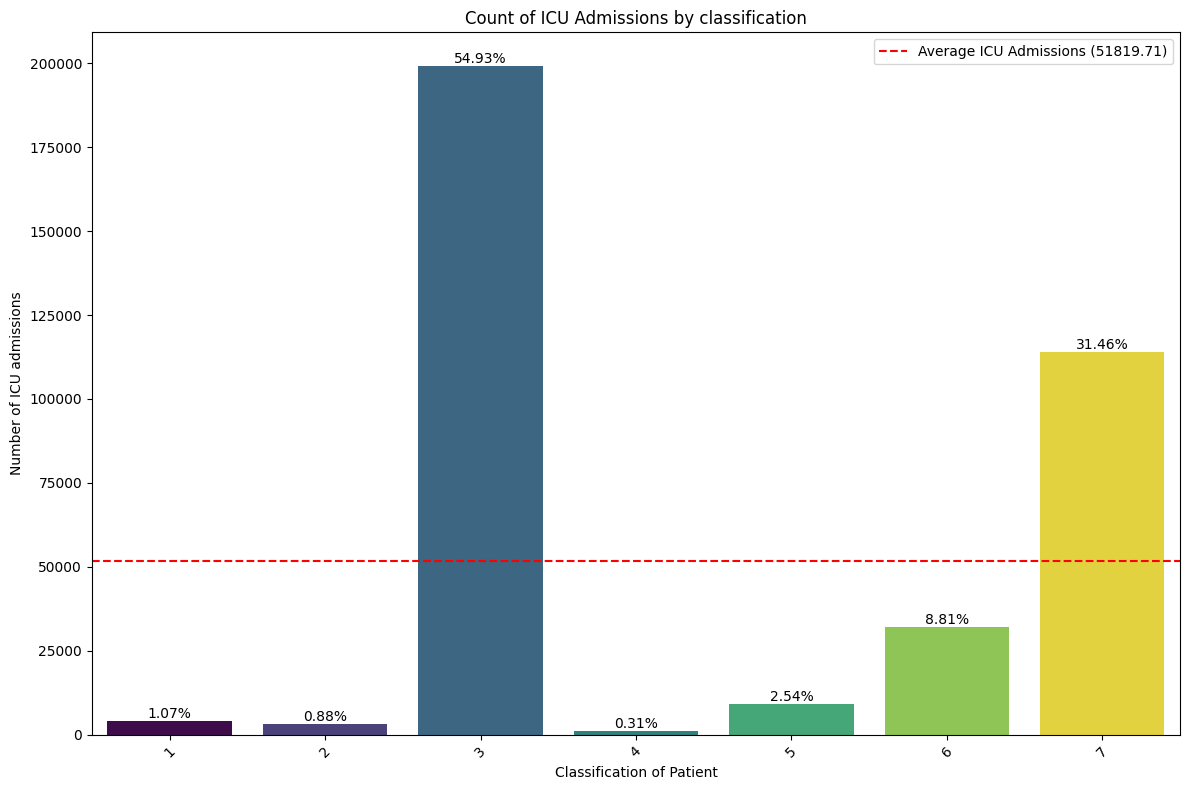

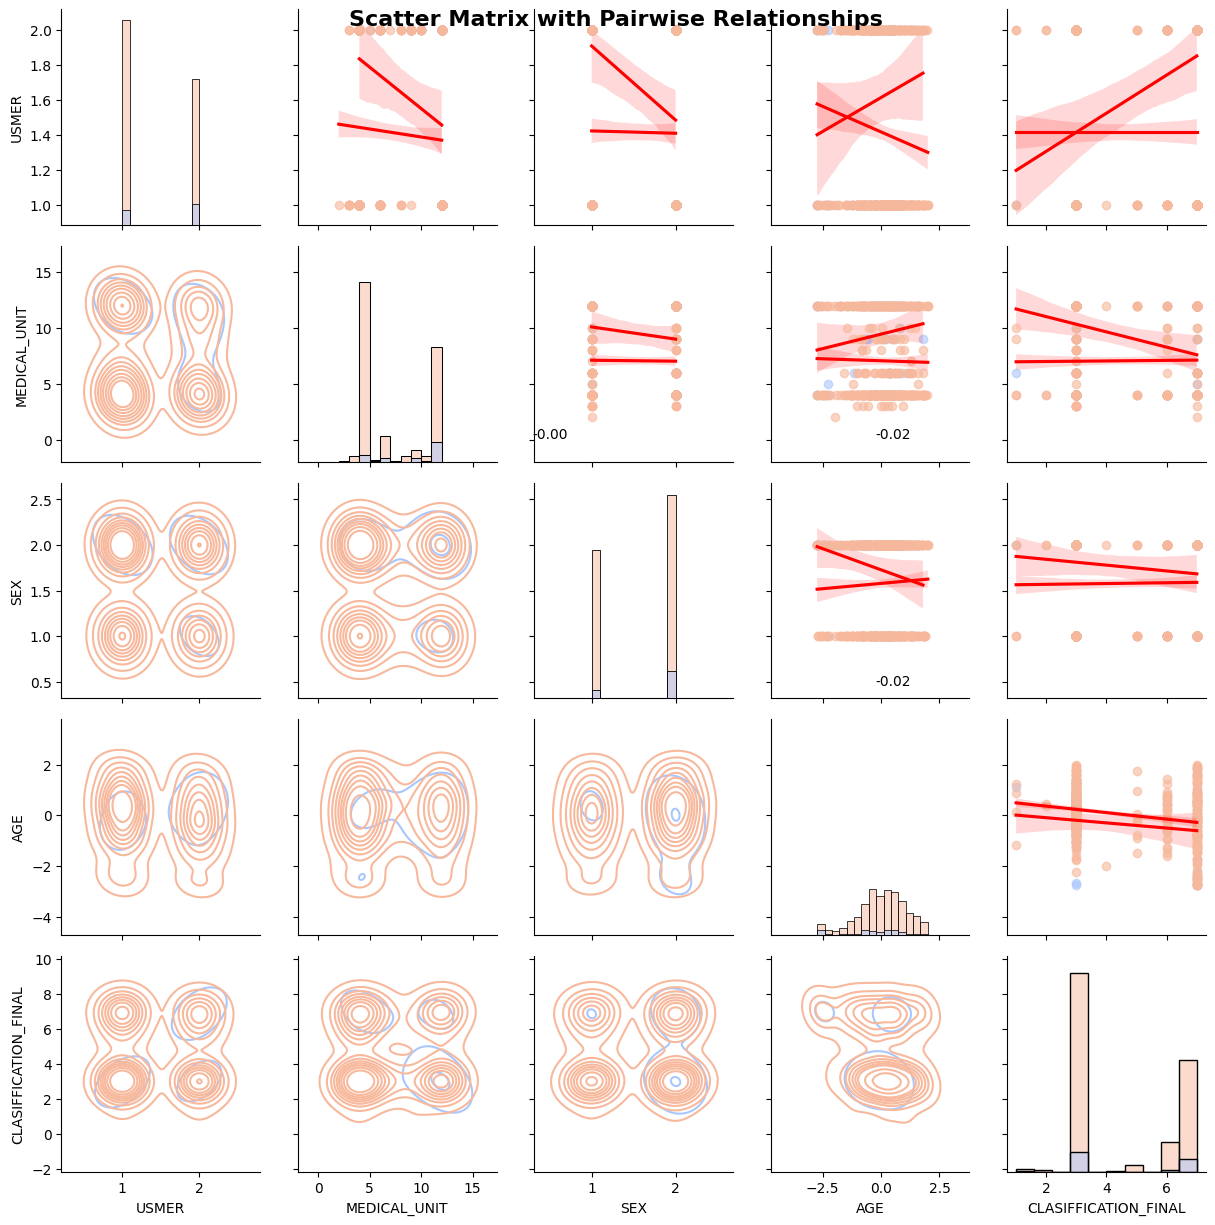

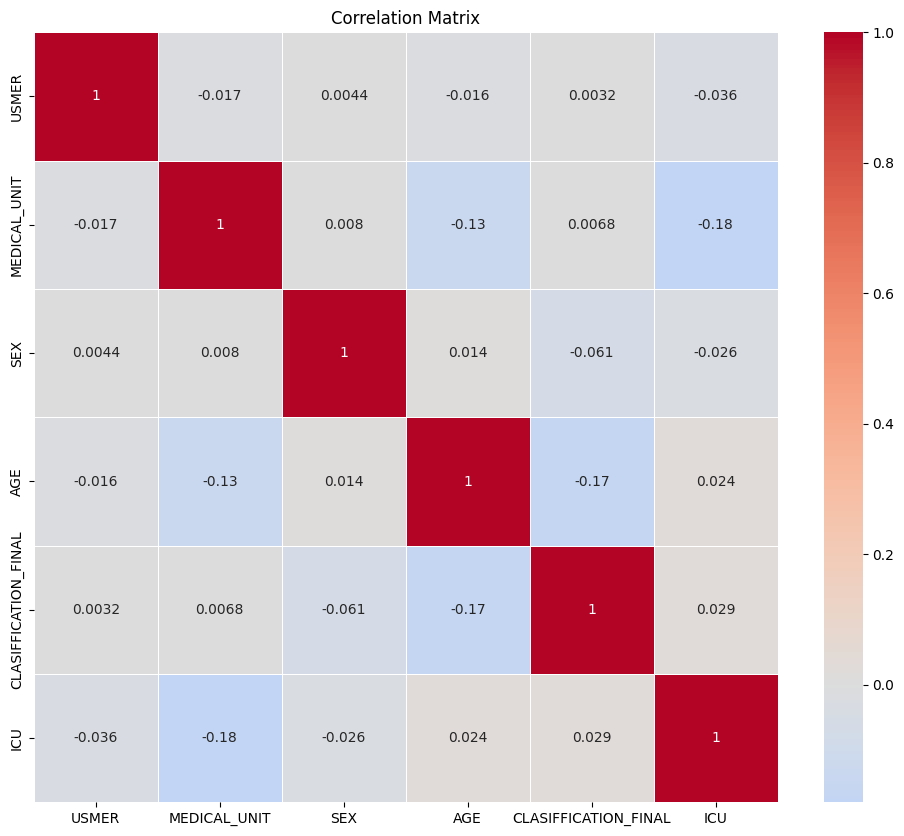

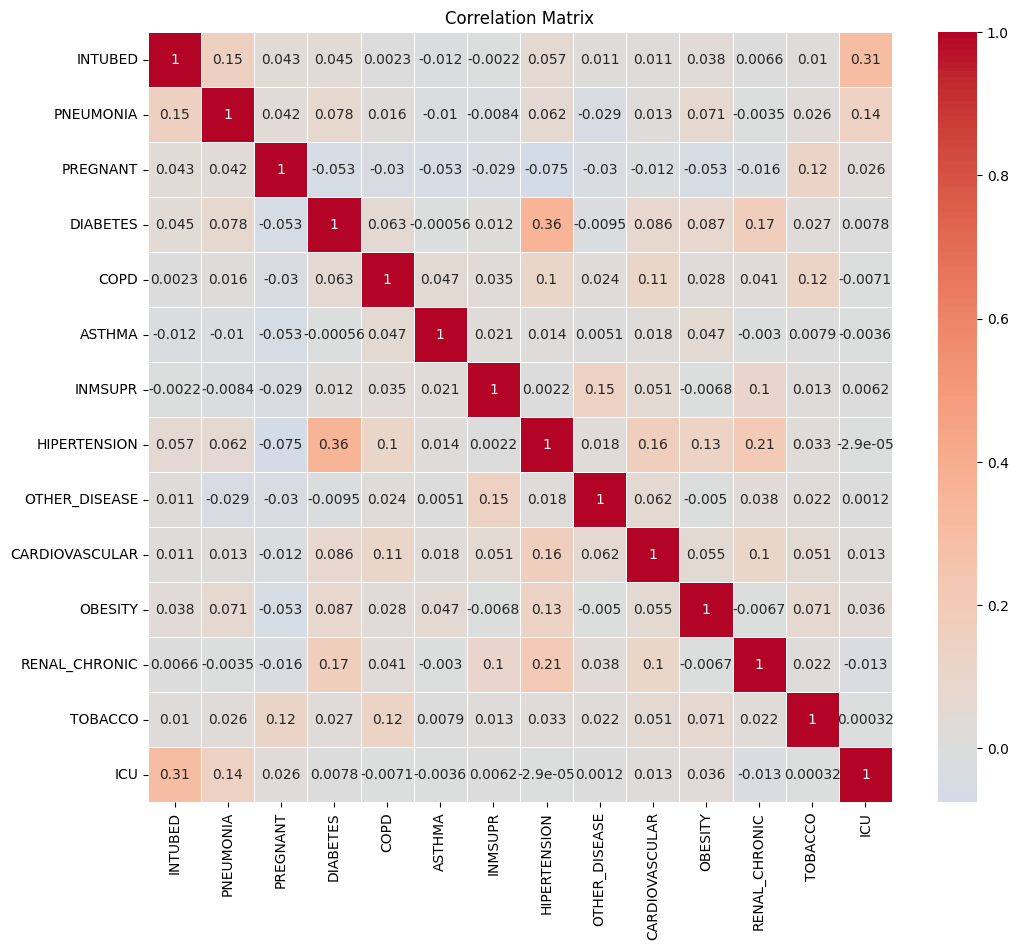

C:\Users\owain\AppData\Local\Temp\ipykernel_39084\3087470711.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


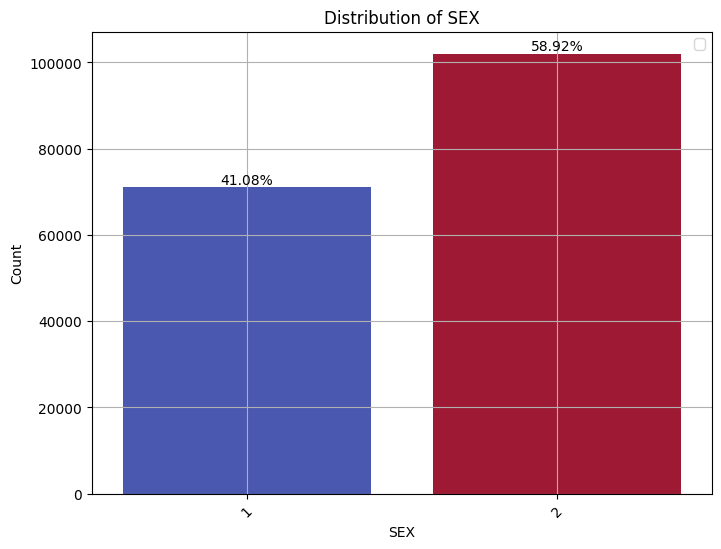

C:\Users\owain\AppData\Local\Temp\ipykernel_39084\3087470711.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


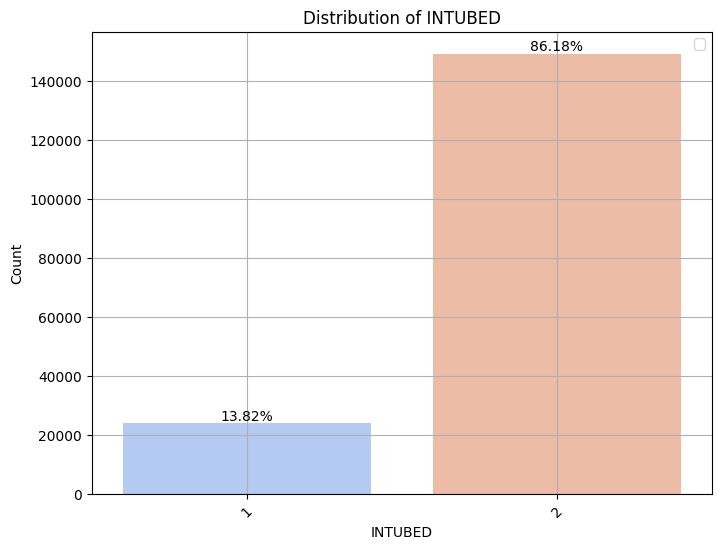

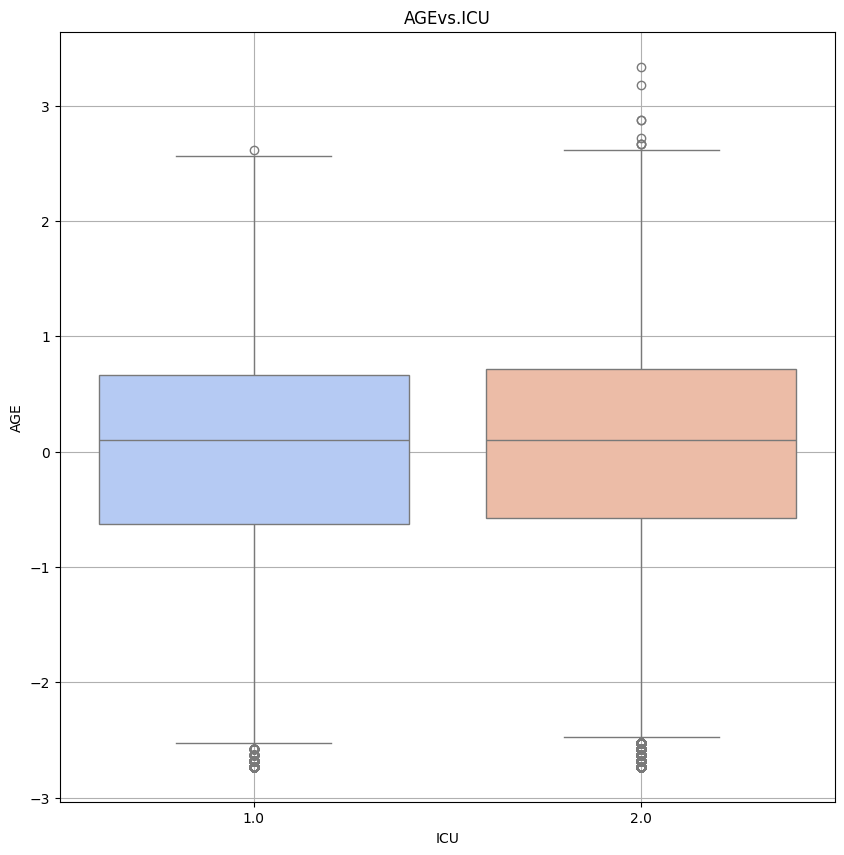

Plotting for CLASIFFICATION_FINAL = 1


C:\Users\owain\AppData\Local\Temp\ipykernel_39084\3087470711.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


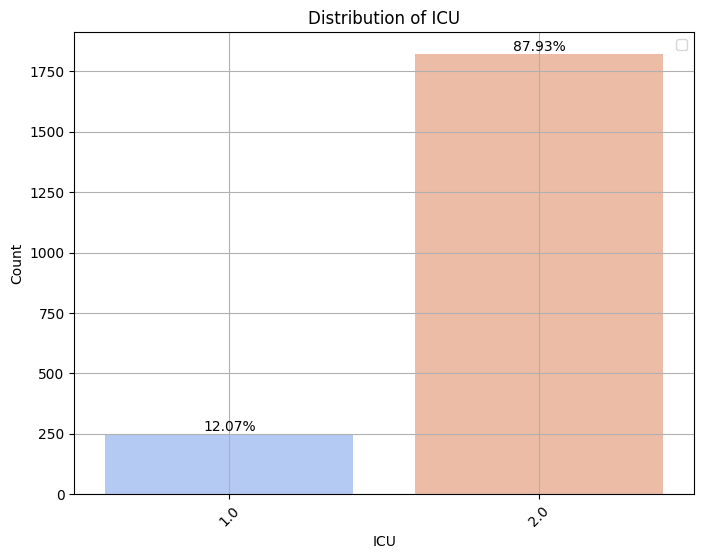

Plotting for CLASIFFICATION_FINAL = 2


C:\Users\owain\AppData\Local\Temp\ipykernel_39084\3087470711.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


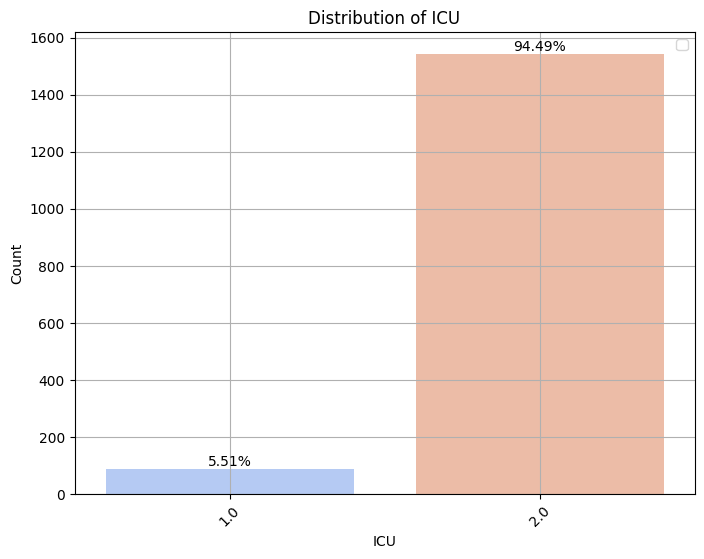

Plotting for CLASIFFICATION_FINAL = 3


C:\Users\owain\AppData\Local\Temp\ipykernel_39084\3087470711.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


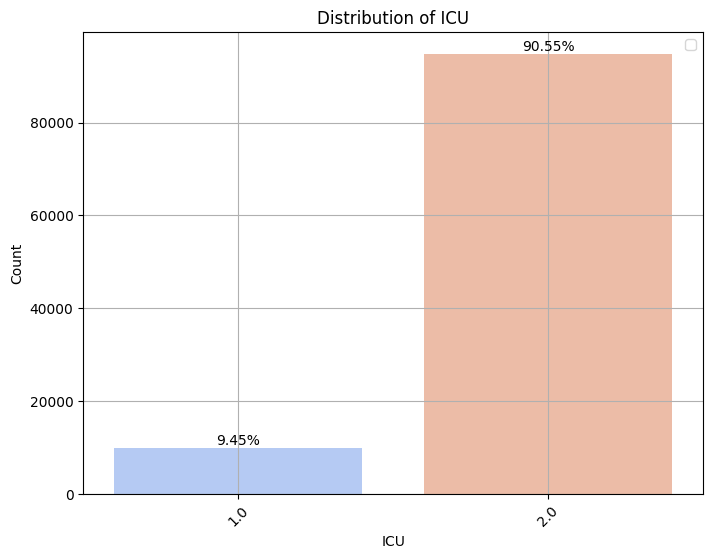

Plotting for CLASIFFICATION_FINAL = 4


C:\Users\owain\AppData\Local\Temp\ipykernel_39084\3087470711.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


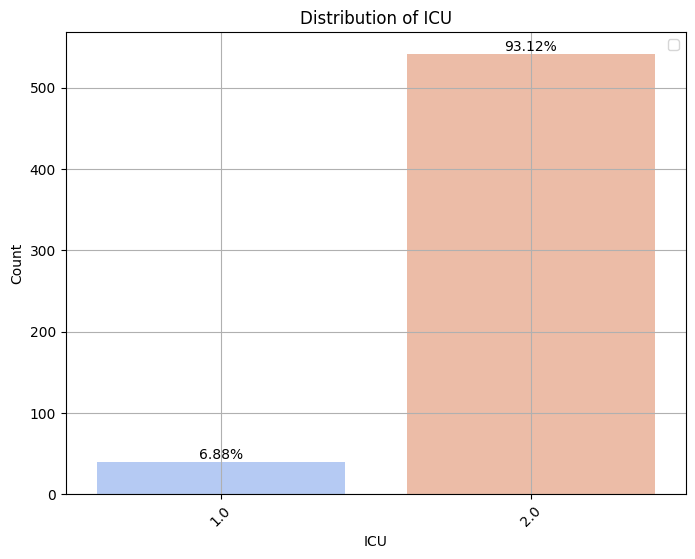

C:\Users\owain\AppData\Local\Temp\ipykernel_39084\3087470711.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Plotting for CLASIFFICATION_FINAL = 5


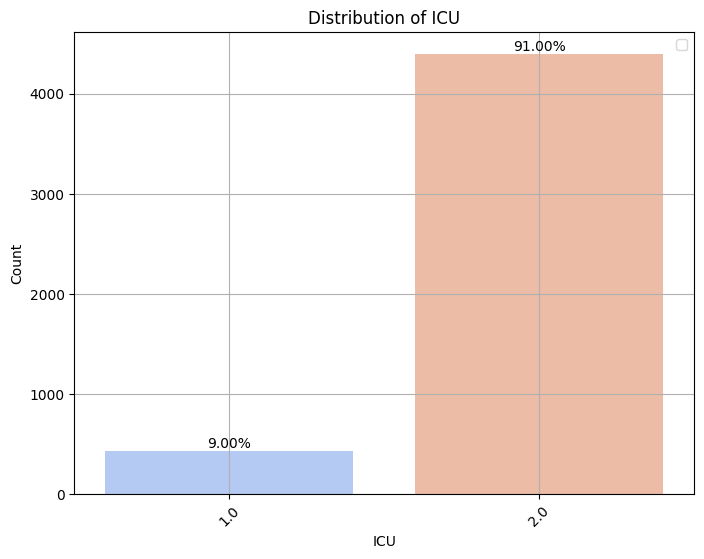

Plotting for CLASIFFICATION_FINAL = 6


C:\Users\owain\AppData\Local\Temp\ipykernel_39084\3087470711.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


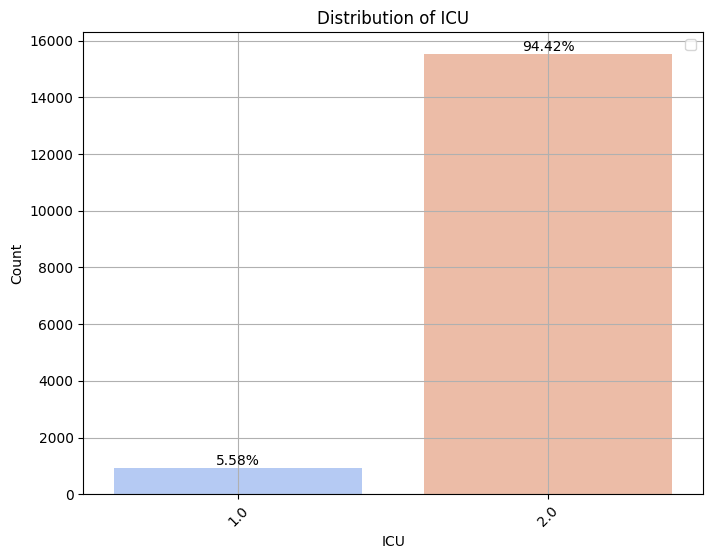

Plotting for CLASIFFICATION_FINAL = 7


C:\Users\owain\AppData\Local\Temp\ipykernel_39084\3087470711.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


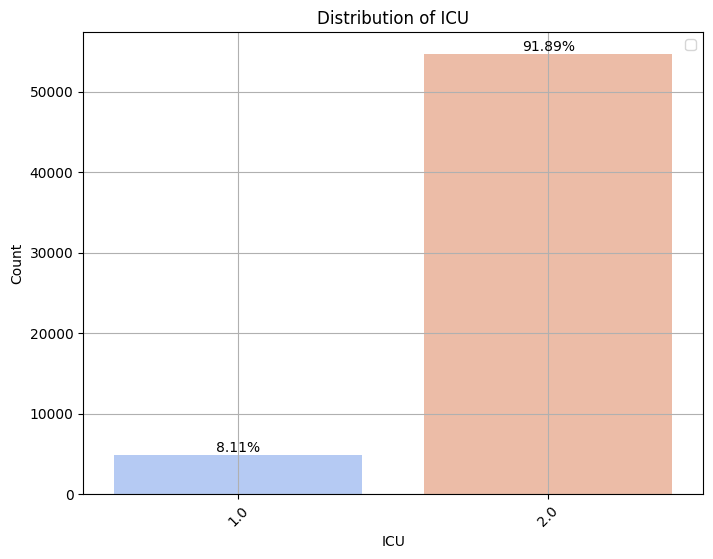

In [16]:

# Task 2: Data Visualisation
df_patients['ICU'] = pd.to_numeric(df_patients['ICU'], errors='coerce')
df_patients['AGE'] = pd.to_numeric(df_patients['AGE'], errors='coerce')
ICU_Cases = df_patients[df_patients['ICU'] == 2.0]

def sampleData(patients_data, numeric_columns):
    sample_df = patients_data[numeric_columns].sample(n=500, random_state=26)
    return sample_df


def countPlotDistribution(patients_data, x_axis):
    plt.figure(figsize=(8, 6))
    graph = sns.countplot(data=patients_data, x=x_axis, hue=x_axis, palette="coolwarm", legend=False)
    total = len(patients_data)
    for i in graph.patches:
        percentage = f'{(i.get_height() / total) * 100:.2f}%'
        graph.annotate(percentage, (i.get_x() + i.get_width() / 2, i.get_height()), ha='center', va='bottom')
    plt.xticks(rotation=45)
    plt.title('Distribution of '+x_axis)
    plt.xlabel(x_axis)
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

def histPlot(ICU_Cases, x_axis, y_axis):
    plt.figure(figsize=(10, 6))
    mean = np.mean(ICU_Cases[x_axis])
    median = np.median(ICU_Cases[x_axis])
    # 10 bins was too little, 100 was too many, 50 was bin goldilocks zone
    sns.histplot(data=ICU_Cases, x=x_axis, bins = 50, kde = True, alpha = 0.8, multiple="stack", stat="density", palette="viridis", hue=y_axis)
    plt.title(y_axis+' vs.'+x_axis)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.axvline(mean, color="b", linestyle="dashed", label="Mean")
    plt.axvline(median, color="g", linestyle="dashed", label="Median")
    plt.legend()
    plt.grid(True)
    plt.show()
    # df_patients.describe()
    # df_patients.to_csv("cleaned_patients.csv", index=False)

def barPlot(patients_data):
    ICU_Counts = patients_data.groupby('CLASIFFICATION_FINAL', as_index=False)['ICU'].sum()
    avg_icu = ICU_Counts['ICU'].mean()
    max_row = ICU_Counts.loc[ICU_Counts['ICU'].idxmax()]
    total = len(patients_data)

    plt.figure(figsize=(12, 8))
    graph = sns.barplot(data=ICU_Counts, x="CLASIFFICATION_FINAL", y="ICU", palette="viridis", errorbar=None, hue="CLASIFFICATION_FINAL", legend=False)
    for i in graph.patches:
        percentage = (i.get_height() / ICU_Counts['ICU'].sum()) * 100
        graph.annotate(f'{percentage:.2f}%', (i.get_x() + i.get_width() / 2, i.get_height()), ha='center', va='bottom')
    #plt.annotate(f"Highest: {max_row['ICU']}", xy=(max_row.name, max_row['ICU']), xytext=(max_row.name, max_row['ICU'] + 5), arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
    plt.title('Count of ICU Admissions by classification')
    plt.xlabel('Classification of Patient')
    plt.ylabel('Number of ICU admissions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.axhline(avg_icu, color='red', linestyle='--', label=f'Average ICU Admissions ({avg_icu:.2f})')
    plt.legend()
    #fig = px.bar(ICU_Counts, x="CLASIFFICATION_FINAL", y="ICU", title="ICU Admissions by Classification", text="ICU")
    #fig.update_traces(textposition='outside')
    #fig.show()
    plt.show()

def pairGrid(patients_data, numeric_columns):
# Scatter Matrix
    patients_data['ICU'] = patients_data['ICU'].astype('category')
    sample_df = sampleData(patients_data, numeric_columns)

    graph = sns.PairGrid(sample_df, palette="coolwarm", hue="ICU", height=2.5)
    #graph.map_upper(sns.scatterplot, color="blue")
    graph.map_upper(sns.regplot, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
    graph.map_lower(sns.kdeplot)
    graph.map_diag(sns.histplot, color="red")#kde_kws={'color': 'red'})
    for i, n in zip(*np.triu_indices_from(graph.axes, 1)):
        correlation = sample_df.iloc[:, 1].corr(sample_df.iloc[:, n])
        graph.axes[i, n].annotate(f'{correlation:.2f}', xy=(0.5, 0.5), ha='center', va='center')
    plt.suptitle('Scatter Matrix with Pairwise Relationships', fontsize=16, fontweight='bold')
    plt.show()

def correlationMatrix(correlation_matrix):
    plt.figure(figsize=(12,10))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, center=0)
    plt.title("Correlation Matrix")
    plt.show()

def boxPlot(patient_data, x_axis, y_axis):
    plt.figure(figsize=(10,10))
    sns.boxplot(data=patient_data, x=x_axis, y=y_axis, palette="coolwarm", hue=x_axis, legend=False)
    plt.title(y_axis+'vs.'+x_axis)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.grid(True)
    plt.show()

def getNumericColumns(patient_data):
    numeric_cols2 = df_patients.select_dtypes(include=['float64', 'int64']).columns
    numeric_cols2 = [col for col in numeric_cols2 if df_patients[col].nunique() > 1]  
    return numeric_cols2

def getCategoricalColumns(patient_data):
    categorical_cols = df_patients.select_dtypes(include=['object']).columns    
    categorical_cols = [col for col in categorical_cols if df_patients[col].nunique() > 1]
    return categorical_cols

# Plot 1: Distribution of the target variable 'ICU'
countPlotDistribution(df_patients, 'ICU')

# Plot 2: Count of number of ICU cases against age.
ICU_Cases = df_patients[df_patients['ICU'] == 2.0]
Non_ICU_Cases = df_patients[df_patients['ICU'] == 1.0]
histPlot(df_patients, 'AGE', 'ICU') 
#histPlot(ICU_Cases, 'AGE', 'ICU')
#histPlot(Non_ICU_Cases, 'AGE', 'ICU')

# Plot 3: Count of ICU admissions versus classification
barPlot(df_patients)

# Plot 4, 5, 6: Scatter matrix plot and correlation matrices
numeric_columns = getNumericColumns(df_patients)
categorical_columns = getCategoricalColumns(df_patients)  
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_patients[col] = le.fit_transform(df_patients[col].astype(str))
    label_encoders[col] = le
    
num_correlation_matrix = df_patients[numeric_columns].corr()
cat_correlation_matrtix = df_patients[categorical_columns + ['ICU']].corr()

pairGrid(df_patients, numeric_columns)
correlationMatrix(num_correlation_matrix)
correlationMatrix(cat_correlation_matrtix)

# Other plots that may be useful
# Plot 7: ICU CASE vs. SEX
countPlotDistribution(ICU_Cases, 'SEX')

# Plot 9: ICU CASE vs. INTUBED
countPlotDistribution(ICU_Cases, 'INTUBED')

# Plot 10 ICU CASE vs. AGE
boxPlot(df_patients, 'ICU', 'AGE') 

# Plots 11-18: ICU CASE vs. Classification 
for classification in range(1, 8):
    classification_patients = df_patients[df_patients['CLASIFFICATION_FINAL'] == classification]

    print(f"Plotting for CLASIFFICATION_FINAL = {classification}")
    
    countPlotDistribution(classification_patients, 'ICU')
